# Gaussian Mixture Models

### The *k*-means clustering model explored in the previous chapter is simple and relatively easy to understand, but its simplicity leads to practical challenges in its application.
### In particular, the nonprobabilistic nature of *k*-means and its use of simple distance from cluster center to assign cluster membership leads to poor performance for many real-world situations.



In [17]:
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

## Gaussian Mixtures: Weaknesses of k-Means

### Let's take a look at some of the weaknesses of *k*-means and think about how we might improve the cluster model.
### Given simple, well-separated data, *k*-means finds suitable clustering results.
### For example, if we have simple blobs of data, the *k*-means algorithm can quickly label those clusters in a way that closely matches what we might do by eye (see the following figure):

In [18]:
# Generate some data

X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
#X = X[:, ::-1] # flip axes for better plotting

/home/ramesh/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


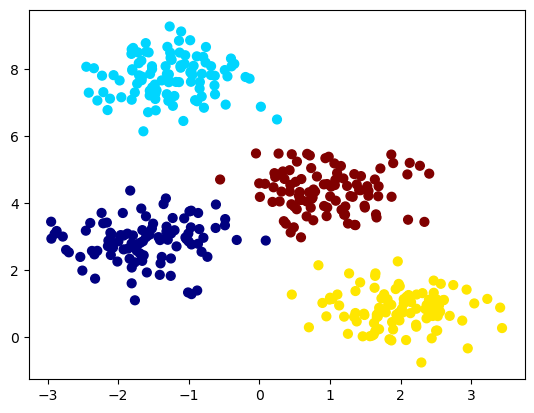

In [19]:
# Plot the data with k-means labels

kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='jet');

### From an intuitive standpoint, we might expect that the clustering assignment for some points is more certain than others: for example, there appears to be a very slight overlap between the two middle clusters, such that we might not have complete confidence in the cluster assignment of points between them.
### Unfortunately, the *k*-means model has no intrinsic measure of probability or uncertainty of cluster assignments (although it may be possible to use a bootstrap approach to estimate this uncertainty).
### One way to think about the *k*-means model is that it places a circle (or, in higher dimensions, a hypersphere) at the center of each cluster, with a radius defined by the most distant point in the cluster.
### This radius acts as a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster.
### An important observation for *k*-means is that these cluster models *must be circular*: *k*-means has no built-in way of accounting for oblong or elliptical clusters.
### So, for example, if we take the same data and transform it, the cluster assignments end up becoming muddled, as you can see in the following figure:

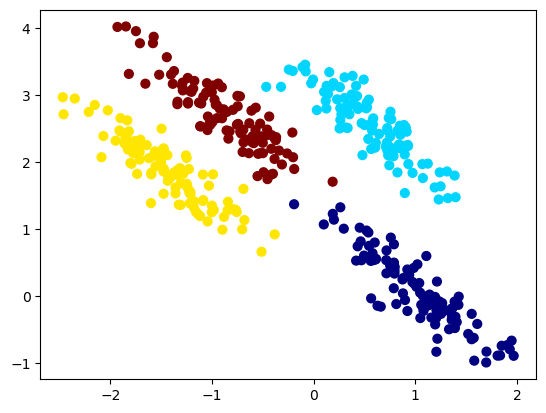

In [20]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))
plt.scatter(X_stretched[:, 0], X_stretched[:, 1], c=labels, s=40, cmap='jet');


/home/ramesh/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


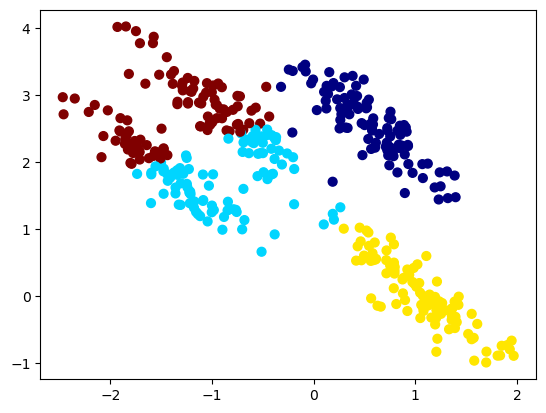

In [21]:
kmeans = KMeans(n_clusters=4, random_state=0)
labels_stretched = kmeans.fit(X_stretched).predict(X_stretched)
plt.scatter(X_stretched[:, 0], X_stretched[:, 1], c=labels_stretched, s=40, cmap='jet');

### By eye, we recognize that these transformed clusters are noncircular, and thus circular clusters would be a poor fit. 
### OF course, keep in mind that in more that 3 dimensions there is no way of doing this by "eye"
### *k*-means is not flexible enough to account for this, and tries to force-fit the data into four circular clusters.

### Two disadvantages of *k*-means—its lack of flexibility in cluster shape and lack of mechanism to evaluate the number of clusters. 

## Gaussian Mixture Models

### A Gaussian mixture model (GMM) attempts to find a mixture of multidimensional Gaussian probability distributions that best model any input dataset.
### In the simplest case, GMMs can be used for finding clusters in the same manner as *k*-means (see the following figure):

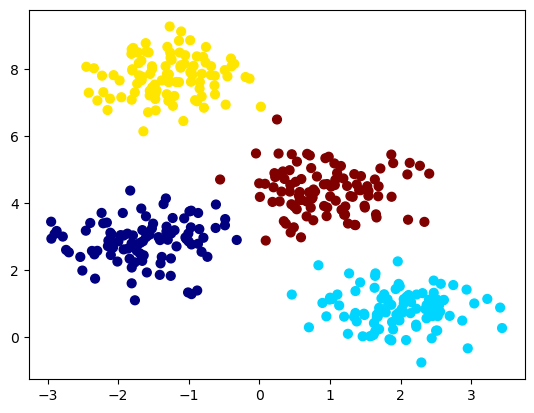

In [22]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='jet');

### But because a GMM contains a probability model under the hood, it is also possible to find **probabilistic cluster assignments** using the `predict_proba` method.
### This returns a matrix of size `[n_samples, n_clusters]` which measures the probability that any point belongs to the given cluster:

In [23]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.    0.469 0.531]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]]


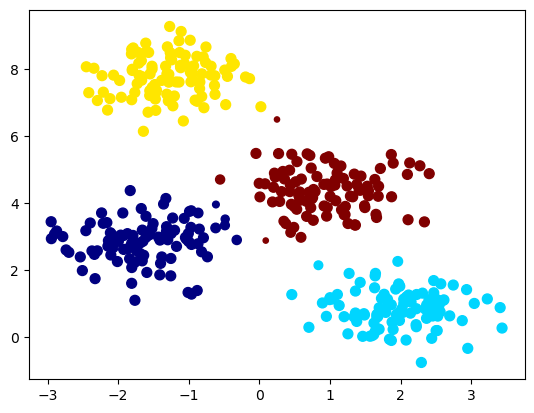

In [24]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='jet', s=size);

### Gaussian mixtures model is very similar to *k*-means: it uses an expectation–maximization approach, which qualitatively does the following:

* ### Choose starting guesses for the location and shape.

* ### Repeat until converged:

   1. ####  *E-step*: For each point, find weights encoding the probability of membership in each cluster.
   2. #### *M-step*: For each cluster, update its location, normalization, and shape based on *all* data points, making use of the weights.

### The result of this is that each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian ellipsoid model.
### Just as in the *k*-means expectation–maximization approach, this algorithm can sometimes miss the globally optimal solution, and thus in practice multiple random initializations are used.
### The notion of an ellipsoid comes from the idea that the cluster boundary has (in 2-dimensions) two axis. In the case of the sphere, there is one value of radius.  In the case of an ellipsoid there are two different "radii" corresponding to the two directions.   

### The GMM approach to fit our stretched dataset; allowing for a full covariance, the model will fit even very oblong, stretched-out clusters, as we can see in the following figure:

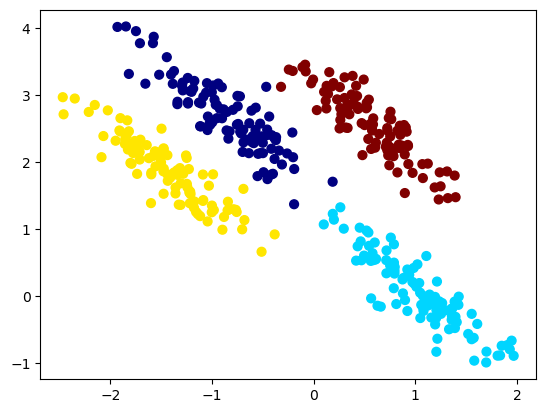

In [25]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
labels_gmm = gmm.fit(X_stretched).predict(X_stretched)
plt.scatter(X_stretched[:, 0], X_stretched[:, 1], c=labels_gmm, s=40, cmap='jet');

This makes clear that GMMs address the two main practical issues with *k*-means encountered before.

### Choosing the Covariance Type
### The `covariance_type` hyperparameter controls the degrees of freedom in the shape of each cluster; it is essential to set this carefully for any given problem.
### The default is `covariance_type="diag"`, which means that the size of the cluster along each dimension can be set independently, with the resulting ellipse constrained to align with the axes.
### A slightly simpler and faster model is `covariance_type="spherical"`, which constrains the shape of the cluster such that all dimensions are equal. The resulting clustering will have similar characteristics to that of *k*-means, though it is not entirely equivalent.
### The model with the most freedom is to use `covariance_type="full"`, which allows each cluster to be modeled as an ellipse with arbitrary orientation.

## Gaussian Mixture Models as Density Estimation

Though the GMM is often categorized as a clustering algorithm, fundamentally it is an algorithm for *density estimation*.
That is to say, the result of a GMM fit to some data is technically not a clustering model, but a generative probabilistic model describing the distribution of the data.


A GMM is convenient as a flexible means of modeling an arbitrary multidimensional distribution of data.

## GMMs for Clustering Digits and Generating New Digits

We just saw a simple example of using a GMM as a generative model in order to create new samples from the distribution defined by the input data.
Here we will run with this idea and generate *new handwritten digits* from the standard digits corpus that we have used before.

To start with, let's load the digits data using Scikit-Learn's data tools:

In [26]:
from sklearn.datasets import load_digits
digits = load_digits()
images = digits.images
data = digits.data
target = digits.target

Next, let's plot the first 50 of these to recall exactly what we're looking at (see the following figure):

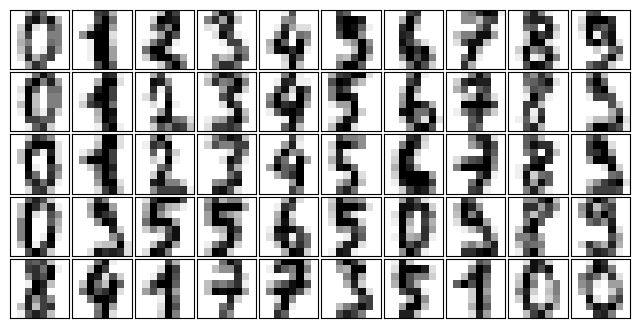

In [27]:
def plot_digits(data):
    fig, ax = plt.subplots(5, 10, figsize=(8, 4),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(data)

### How Many Components?

### The fact that a GMM is a generative model gives us a natural means of determining the optimal number of components for a given dataset.
### A generative model is inherently a probability distribution for the dataset, and so we can simply evaluate the *likelihood* of the data under the model, using cross-validation to avoid overfitting.
### Another means of correcting for overfitting is to adjust the model likelihoods using some analytic criterion such as the Akaike information criterion (AIC) or the [Bayesian information criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion).
### Scikit-Learn's `GaussianMixture` estimator actually includes built-in methods that compute both of these, so it is very easy to operate using this approach.

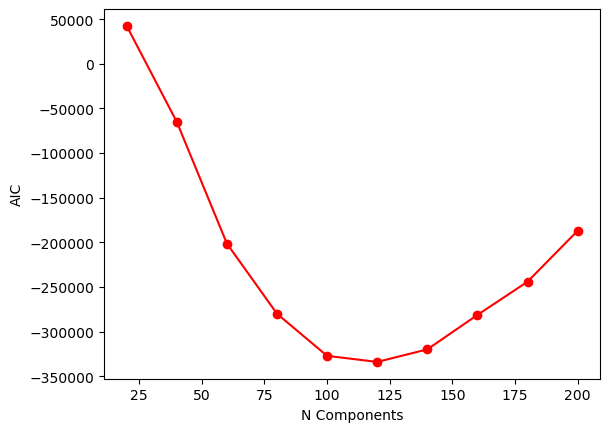

In [28]:
n_components = np.arange(20, 210, 20)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics,'ro-');
plt.xlabel('N Components')
plt.ylabel('AIC')
plt.show()

### The optimal number of clusters is the value that minimizes the AIC, depending on which approximation we wish to use. The AIC tells us that 120 distributions is the best choice of the values we tested
### Notice the important point: this choice of number of components measures how well a GMM works *as a density estimator*, not how well it works *as a clustering algorithm*.

In [29]:
gmm = GaussianMixture(120, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


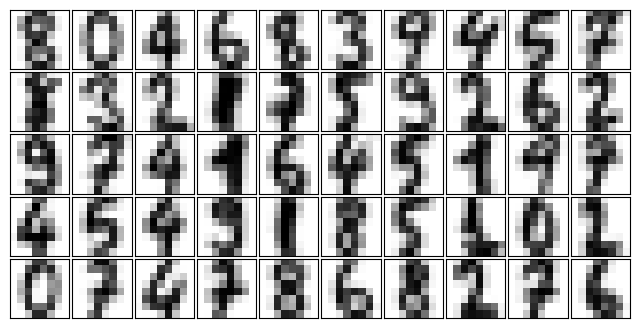

In [30]:
plot_digits(gmm.means_)

### The really interesting thing for generative modeling (see COGS 107) is that now we can draw samples of 100 new samples, using the GMM as a generative model:

In [31]:
data_new, label_new = gmm.sample(100)
data_new.shape

(100, 64)

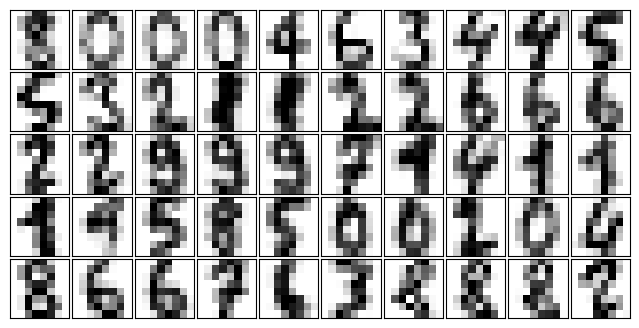

In [32]:
plot_digits(data_new)

### Consider what we've done here: given a sampling of handwritten digits, we have modeled the distribution of that data in such a way that we can generate brand new samples of digits from the data: these are "handwritten digits," which do not individually appear in the original dataset, but rather capture the general features of the input data as modeled by the mixture model.